In [9]:
import importlib
from utils import set_root
#from utils import PhysioLoader
import math
set_root()
%cd ..

Current working directory: /home/manni/physioex
/home/manni


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%ls

cap@   dreem/  isruc@           mass@        mne_data_old/  physioex/  svuh@
dcsm@  hmc@    lightning_logs/  miniconda3/  models/        plots/
deap@  hpap@   mahnob@          mne_data/    physio2018@    shhs@


## Plotting Signals

In [4]:
# importing
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from typing import List

from loguru import logger

logger.remove()

In [ ]:
models = ["seqsleepnet_cem"]
dataset = {"name": "sleep_merged", "version": "/"}
seqlen = 1
loss = "cel"
batch_size = 32

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
if dataset["name"] == "mitdb":
    sleep_stages = ["N", "S", "V", "F", "Q"]

labels_idx = np.arange(len(sleep_stages)).astype(int)
labels_idx_concept = np.arange(len(sleep_stages)).astype(int)

In [ ]:
import torch.nn.functional as Fun

def gaussian_kernel(size, sigma=0.6):
        """Create a 2D Gaussian kernel."""
        kernel = torch.tensor([[i, j] for i in range(size) for j in range(size)], dtype=torch.float32)
        mean = (size - 1) / 2.0
        variance = sigma**2
        
        # Calculate the Gaussian distribution
        kernel = torch.exp(-(torch.sum((kernel - mean)**2, dim=1)) / (2.0 * variance))
        kernel = kernel / torch.sum(kernel)
        
        # Reshape to a 2D matrix
        return kernel.reshape(size, size).unsqueeze(0).unsqueeze(0)

gaussian_kernel = gaussian_kernel(3)
print(gaussian_kernel)

def apply_smoothing(tensor: torch.Tensor):
        # Estrai le dimensioni del tensore
        batch_size, L, C, height, width = tensor.size()
        
        kernel = gaussian_kernel.to(tensor.device)
        
        # Per applicare la convoluzione, dobbiamo appiattire il tensore lungo la dimensione del batch e dei canali
        tensor = tensor.view(batch_size * L * C, 1, height, width)
        
        # Applica la convoluzione 2D con padding per mantenere la dimensione dell'immagine
        smoothed_tensor = Fun.conv2d(tensor, kernel, padding=kernel.size(3)//2)
        #print("smoothed_tensor:", smoothed_tensor.size())
        
        # Ripristina le dimensioni originali
        smoothed_tensor = smoothed_tensor.view(batch_size, L, C, height, width)
        #print("smoothed_tensor view:", smoothed_tensor.size())

        return smoothed_tensor

tensor([[[[0.0277, 0.1110, 0.0277],
          [0.1110, 0.4452, 0.1110],
          [0.0277, 0.1110, 0.0277]]]])


In [ ]:
import seaborn as sns
def plotTheSpectrogram(spectrogram_tensor, max, min):
    spectrogram_array = spectrogram_tensor.numpy()
    
    plt.figure(figsize=(10, 4))
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='coolwarm')
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True,vmax=max, vmin=min)

    #plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Frequency')
    plt.ylabel('Time')
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import re
import torch
from loguru import logger
import pytorch_lightning as pl
from physioex.train.networks.ae_fullyconnected import AutoEncoderFullyConnected
from physioex.train.networks.ae_conv3d import AutoEncoderConv3D

# import importlib.util
# file_path = "physioex/physioex/train/networks/" + name + ".py"
# module_name = "AutoEncoderConv3D"
# spec = importlib.util.spec_from_file_location(module_name, file_path)
# module = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(module)


from physioex.data import TimeDistributedModule, datasets
from physioex.train.networks import config
from physioex.train.networks.utils.loss import config as loss_config

class PhysioLoader:
    def __init__(
        self,
        model_name: str = "chambon2018",
        dataset_name: str = "sleep_physionet",
        loss_name: str = "cel",
        ckp_path: str = None,
        version: str = "2018",
        picks: List[str] = ["EEG"],
        sequence_length: int = 1,
        batch_size: int = 32,
        module = None,
    ):
        if ckp_path is None:
            raise ValueError("ckp_path must be provided")
        if not os.path.isdir(ckp_path):
            raise ValueError(
                "ckp_path must be a valid directory containing at least one checkpoint"
            )
        self.module = module
        self.model_name = model_name
        self.model_call = config[model_name]["module"]
        self.input_transform = config[model_name]["input_transform"]
        self.target_transform = None
        self.module_config = config[model_name]["module_config"]
        self.module_config["seq_len"] = sequence_length
        self.seq_len = sequence_length
        self.picks = picks
        #self.module_config["loss_call"] = loss_config[loss_name]
        #self.module_config["loss_params"] = dict()

        self.module_config["in_channels"] = len(picks)
        self.module_config["loss_call"] = loss_config[loss_name]

        self.batch_size = batch_size
        self.version = version

        logger.info("Scanning checkpoint directory...")
        self.checkpoints = {
            int(re.search(r"fold=(\d+)", elem.name).group(1)): elem.path
            for elem in os.scandir(ckp_path)
            if elem.is_file()
            and elem.name.endswith(".ckpt")
            and re.search(r"fold=(\d+)", elem.name)
        }

        logger.info(f"Found {len(self.checkpoints)} checkpoints")

        self.ckpt_path = ckp_path

        logger.info("Loading dataset")
        self.dataset_call = datasets[dataset_name]

        self.dataset = self.dataset_call(
            version=self.version,
            picks=picks,
            preprocessing=self.input_transform,
            sequence_length=self.seq_len,
            target_transform=None,
        )
        logger.info("Dataset loaded")

    def get_fold(self, fold: int = 0):

        logger.info(
            "JOB:%d-Splitting dataset into train, validation and test sets" % fold
        )
        self.dataset.split(fold)
        
        datamodule = TimeDistributedModule(
            dataset = self.dataset,
            batch_size = batch_size,
            fold = fold,
        )
        
        #self.module_config["loss_params"]["class_weights"] = datamodule.class_weights
        
    
        #model = self.model_call(module_config=self.module_config).load_from_checkpoint(
        model = self.module.load_from_checkpoint(
            self.checkpoints[fold], module_config=self.module_config
        ).eval()

        model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = model.to(model_device)
        train = datamodule.train_dataloader()
        test = datamodule.test_dataloader()
        valid = datamodule.val_dataloader()

        return model, train, valid, test
    

In [ ]:
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet
name = "ae_seqsleepnet"
module = AutoEncoderSeqSleepNet

ckp_path = "models/" + name +"/seqlen=3/merged/EEG_epoch2_norm"

loader = PhysioLoader(
    model_name=name,
    loss_name = "mse",
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
    module= module
)

model, _, _,  test_loader = loader.get_fold(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Imposta il modello in modalità di valutazione
model = model.eval().to(device)


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
del AutoEncoderSeqSleepNet
import physioex.train.networks.ae_seqsleepnet
importlib.reload(physioex.train.networks.ae_seqsleepnet)
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet

In [ ]:
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet
name2 = "ae_seqsleepnet"
module2 = AutoEncoderSeqSleepNet

ckp_path2 = "models/" + name2 +"/seqlen=3/merged/EEG_epoch2_norm2"

loader2 = PhysioLoader(
    model_name=name2,
    loss_name = "mse",
    ckp_path=ckp_path2,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
    module= module2
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2, _, _, test_loader2  = loader2.get_fold(0)
model2 = model2.eval().to(device)

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from physioex.train.networks.ae_conv3d import AutoEncoderConv3D
name3 = "ae_conv3d"
module3 = AutoEncoderSeqSleepNet

ckp_path3 = "models/" + name3 +"/seqlen=3/merged/EEG_test8"

loader3 = PhysioLoader(
    model_name=name3,
    loss_name = "mse",
    ckp_path=ckp_path3,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
    module= module3
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3, _, _, test_loader3  = loader3.get_fold(0)
model3 = model3.eval().to(device)

ValueError: ckp_path must be a valid directory containing at least one checkpoint

  0%|          | 0/832 [00:00<?, ?it/s]/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Awake


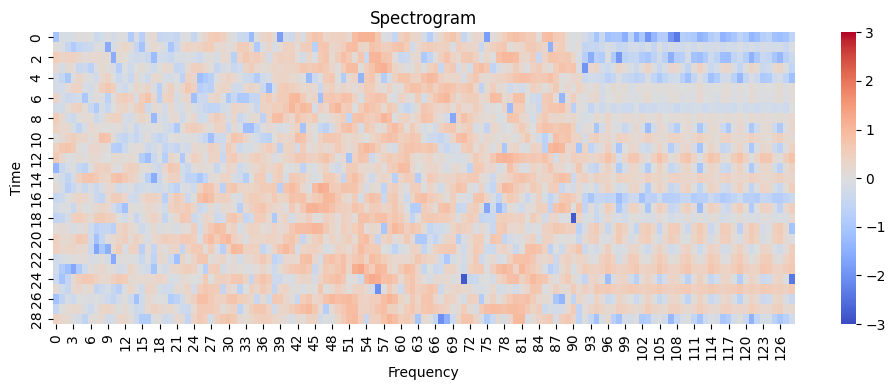

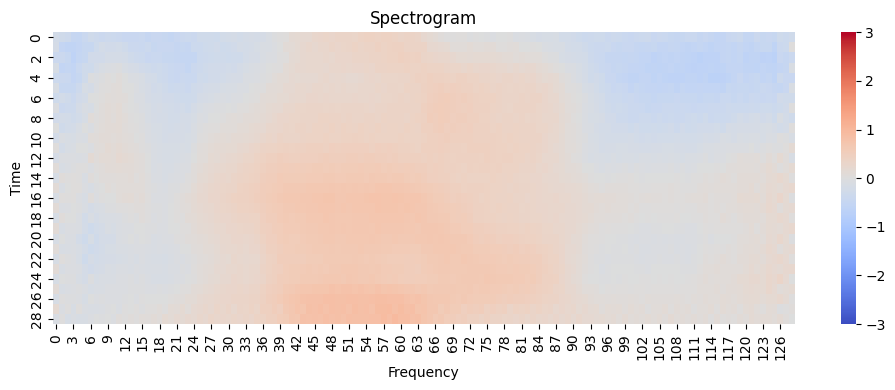

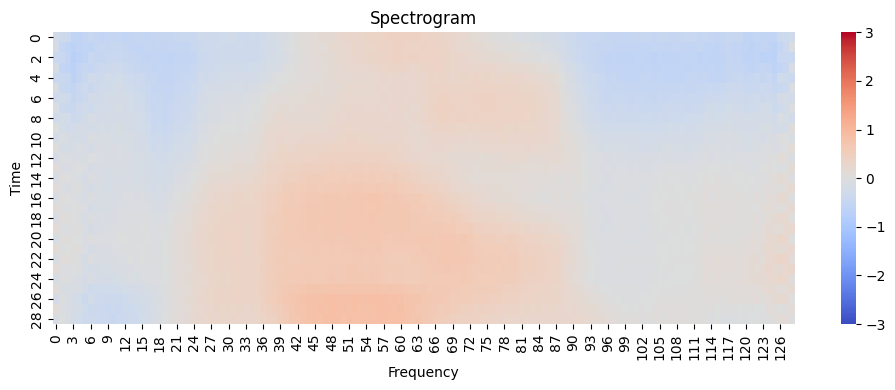

  0%|          | 0/832 [00:03<?, ?it/s]


In [ ]:
for i in range(len(loader.checkpoints)):

    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            indici = np.argwhere(labels.squeeze() == 2) 
            indices_list = indici.tolist()[0] # 0 per la classe awake, 1 per la classe N1 ecc
            if(len(indices_list) > 15):
                #print(indices_list)
                #print(labels.squeeze())
                # Calcola le previsioni del modello
                index = indices_list[3]
                print(sleep_stages[labels[index][0].item()]) #0 perchè prendo la prima epoca
                
                input_hat = model(inputs.to(device))
                input_hat2 = model2(inputs.to(device))
                x_smoothed = apply_smoothing(inputs)[index][0][0]
                
                # print("inputs:", inputs.size())
                # print("x_smoothed:", x_smoothed.size())
                # print("input_hat:", input_hat.size())

                x = inputs[index][0][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
                # max = x.max()
                # min = x.min()
                max = 3
                min = -3

                x_hat = input_hat[index].to("cpu")[0][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale 
                max_ = x_hat.max()
                min_ = x_hat.min()

                #print("shape x: ", x.shape)
                plotTheSpectrogram(x, max, min)
                
                # print("shape x_smoothed: ", x_smoothed.shape)
                # plotTheSpectrogram(x_smoothed, max, min)
                
                
                #print("shape x_hat: ", x_hat.shape)
                plotTheSpectrogram(x_hat, max, min)

                x_hat2 = input_hat2[index].to("cpu")[0][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
                #print("shape x_hat2: ", x_hat2.shape)
                plotTheSpectrogram(x_hat2, max, min)
                break


In [ ]:
import torch
import torch.nn as nn

a = torch.tensor([[10, 0, 5], [0, 0, -20]], dtype=torch.float32)
b = torch.tensor([[10, 0, 5], [0, 0, -20], [0, 0, -20], [0, 0, -20]], dtype=torch.float32)

ln = nn.LayerNorm((3))

a_ = ln(a)
b_ = ln(b)

print(a_)
print(b_)

tensor([[ 1.2247, -1.2247,  0.0000],
        [ 0.7071,  0.7071, -1.4142]], grad_fn=<NativeLayerNormBackward0>)
tensor([[ 1.2247, -1.2247,  0.0000],
        [ 0.7071,  0.7071, -1.4142],
        [ 0.7071,  0.7071, -1.4142],
        [ 0.7071,  0.7071, -1.4142]], grad_fn=<NativeLayerNormBackward0>)


## Model Load

In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm

from pytorch_lightning import seed_everything

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/manni/physioex


In [2]:
%ls

LICENSE*                             models/
README.md*                           multi-source-domain.yaml*
__pycache__/                         my_experiment.yaml*
docs/                                physioex/
embeddings_mass_ssh_conv3d.npy       physioex.egg-info/
embeddings_mass_ssh_seqsleepnet.npy  requirements.txt*
examples/                            scheduler.txt*
labels_mass_ssh_conv3d.npy           setup.py*
labels_mass_ssh_seqsleepnet.npy      teacher_student.py*
lightning_logs/                      teacherstudent.yaml*
main.py*                             temp/
mkdocs.yml*                          typescript*


In [3]:
from physioex.data import TimeDistributedModule, SleepEDF, Shhs, SleepMerged

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.train.networks.utils.target_transform import get_mid_label

In [4]:
# importing
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [6]:
def get_single_file_path(directory):
    # Lista di tutti i file nella cartella
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Controlla che ci sia un solo file nella cartella
    if len(files) == 1:
        return os.path.join(directory, files[0])
    else:
        raise ValueError("La cartella non contiene esattamente un file.")

# model parameters
model_name1 = "ae_conv3d"
model_name2 = "ae_conv3d"
model_name3 = "ae_seqsleepnet"
checkpoint1 = get_single_file_path('../physioex/models/ae_conv3d/seqlen=3/merged/EEG')
checkpoint2 = get_single_file_path('../physioex/models/ae_conv3d/seqlen=3/merged_mass_shhs/EEG')
checkpoint3 = get_single_file_path('../physioex/models/ae_seqsleepnet/seqlen=3/merged_mass_shhs/EEG')
sequence_length = 3

# dataset
picks = ["EEG"]
fold = 0

# dataloader
batch_size = 32
num_workers = 32

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#results_dir = f"results/{model_name}/"

In [7]:
import seaborn as sns
def plotTheSpectrogram(spectrogram_tensor, max, min):
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
    
    plt.figure(figsize=(5, 5))
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='coolwarm')
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True,vmax=max, vmin=min)

    #plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [8]:
# load dataset and model
model = networks[model_name1]
model2 = networks[model_name2]
model3 = networks[model_name3]

dataset = SleepMerged(
    picks=picks,
    sequence_length=sequence_length,
    # target_transform=model["target_transform"],
    target_transform=get_mid_label,
    preprocessing=model["input_transform"],
)

dataset.split(fold=fold)

dataset = TimeDistributedModule(
    dataset=dataset, batch_size=batch_size, fold=fold
)

# model1 = load_pretrained_model(
#     name=model_name1,
#     in_channels=len(picks),
#     sequence_length=sequence_length,
#     softmax=False,
#     loss = "mse",
#     ckpt_path=checkpoint1
# ).eval()

model2 = load_pretrained_model(
    name=model_name2,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint2
).eval()

model3 = load_pretrained_model(
    name=model_name3,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint3
).eval()

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [19]:
# class MidModel(torch.nn.Module):
#     def __init__(self, model):
#         super(MidModel, self).__init__()
#         self.model = model

#     def forward(self, x):
#         return self.model(x)[:, int((x.shape[1] - 1) / 2)]


# model1 = MidModel(model1)
# model2 = MidModel(model2)
# model3 = MidModel(model3)

In [16]:
# compute the metrics on the test set
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
dataloder = dataset.test_dataloader()

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        print("inputs:", inputs.size())
        print("labels:", labels.size())
        indici = np.argwhere(labels.squeeze() == 1) # 0 per la classe awake, 1 per la classe N1 ecc
        print(indici)
        indices_list = indici.tolist()[0]
        if(len(indices_list) > 2):
            #print(indices_list)
            #print(labels.squeeze())
            # Calcola le previsioni del modello
            index = indices_list[3]
            print(sleep_stages[labels[index].item()])
            
            #input_hat = model1(inputs.to(device))
            input_hat2 = model2(inputs.to(device))
            input_hat3 = model3(inputs.to(device))
            
            # print("inputs:", inputs.size())
            # print("x_smoothed:", x_smoothed.size())
            # print("input_hat:", input_hat.size())
            print(inputs.size())
            #print (input_hat.size())
            x = inputs[index][1][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
            print(x.size())
            # max = x.max()
            # min = x.min()
            max = 3
            min = -3

            
            #x_hat = input_hat[index].to("cpu")[1][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
            #max_ = x_hat.max()
            #min_ = x_hat.min()

            #print("shape x: ", x.shape)
            plotTheSpectrogram(x, max, min)
            
            # print("shape x_smoothed: ", x_smoothed.shape)
            # plotTheSpectrogram(x_smoothed, max, min)
            
            
            #print("shape x_hat: ", x_hat.shape)
            #plotTheSpectrogram(x_hat, max, min)

            x_hat2 = input_hat2[index].to("cpu")[1][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
            #print("shape x_hat2: ", x_hat2.shape)
            plotTheSpectrogram(x_hat2, max, min)
            x_hat3 = input_hat3[index].to("cpu")[1][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
            #print("shape x_hat2: ", x_hat2.shape)
            plotTheSpectrogram(x_hat3, max, min)
            break

# y_true = torch.stack(y_true).numpy()
# y_pred = torch.stack(y_pred).numpy()
# pred_probas = torch.stack(pred_probas).numpy()

NameError: name 'dataset' is not defined

## Visualize Embeddings

In [21]:
# compute the metrics on the test set
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
dataloder = dataset.test_dataloader()
num = len(dataloder)*batch_size
emb_dim = 32

embeddings_array = np.empty((num, emb_dim))
labels_array = np.empty((num))

batch = 0
epoch = 1
print(embeddings_array.shape)
print(labels_array.shape)


(1676064, 32)
(1676064,)


In [22]:
print(labels_array[0])
print("embeddings_array:", embeddings_array[0])

1.04141955e-315
embeddings_array: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        #print(sleep_stages[labels[batch].item()])
        input_hat3 = model3(inputs.to(device))
        embedding = model3.nn.encoder(inputs.to(device)).permute(1, 0, 2)
        #embedding = model3.nn.encode(inputs.to(device)).permute(1, 0, 2)
        #print(embedding)
        embeddings_array[i*batch_size : i*batch_size+batch_size] = embedding[epoch].cpu().numpy() 
        labels_array[i*batch_size : i*batch_size+batch_size] = labels.cpu().numpy()


#fin

In [13]:
#embeddings_array_ref = embeddings_array[0:30975] #edf dreem
embeddings_array_ref = embeddings_array[0:1676032] #edf dreem mass shhs

In [14]:
#labels_array_ref = labels_array[0:30975] # edf dreem
labels_array_ref = labels_array[0:1676032] # edf dreem mass shhs

In [16]:
#np.save('embeddings_mass_ssh.npy', embeddings_array_ref)
#np.save('labels_mass_ssh.npy', labels_array_ref)

In [5]:
embeddings_array_ref = np.load('embeddings_mass_ssh_seqsleepnet.npy')
labels_array_ref = np.load('labels_mass_ssh_seqsleepnet.npy')

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from pandas.plotting import parallel_coordinates

palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF" ])

from matplotlib.colors import LinearSegmentedColormap
colori_personalizzati =["#808080","#FF0000","#FFA500","#00FF00", "#0000FF" ]
# Creazione della colormap
colormap_personalizzata = LinearSegmentedColormap.from_list('nome_colormap', colori_personalizzati, N=5)

def plot_pca_2d(data, colors, percentage=1):
    # Perform PCA to reduce to 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]
    
    plt.figure(figsize=(10, 8))
    # Define a palette with 5 distinct colors
    scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)
    plt.title('2D PCA of 32-dimensional data')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f} variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f} variance)')
    plt.legend(title='Color')
    plt.grid(True)
    plt.show()

def plot_pca_3d(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Plotting the results in 3D with color
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, cmap=colormap_personalizzata, alpha=0.8)
    ax.set_title('3D PCA of 32-dimensional data')
    ax.set_xlabel(f'PC 1 ({explained_variance[0]:.2f} variance)')
    ax.set_ylabel(f'PC 2 ({explained_variance[1]:.2f} variance)')
    ax.set_zlabel(f'PC 3 ({explained_variance[2]:.2f} variance)')
    plt.colorbar(scatter, ax=ax, label='Color')
    plt.show()

def plot_pca_3d_i(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Create a DataFrame for Plotly
    import pandas as pd
    df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'PC3': pca_result[:, 2],
        'Color': colors
    })
    # Plotting the results in 3D with color
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color',
                        title='3D PCA of 32-dimensional data',
                        labels={'PC1': f'PC 1 ({explained_variance[0]:.2f} variance)',
                                'PC2': f'PC 2 ({explained_variance[1]:.2f} variance)',
                                'PC3': f'PC 3 ({explained_variance[2]:.2f} variance)'},
                        color_continuous_scale='Viridis')
    fig.update_layout(width=800,height=1000,)
    fig.update_traces(marker=dict(colorscale='Viridis'))
    fig.show()

def plot_tnse_2d(data, colors, percentage=1):
    # Applicare TSNE
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        tsne_results = data[random_indices]
        colors = colors[random_indices]

    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(data)

    # Visualizzare i risultati
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap="viridis", marker='o')
    plt.colorbar(ticks=range(5))
    plt.clim(-0.5, 2.5)
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.title('t-SNE visualization of Iris dataset')
    plt.show()

def plot_parcord(data, colors, percentage=1):
    if (percentage<1):
            num_elements = int(len(data) * percentage)
            random_indices = np.random.choice(len(data), num_elements, replace=False)

            # Create new sampled arrays
            data = embeddings_array_ref[random_indices]
            colors = colors[random_indices]

    df = pd.DataFrame(data[:,:])
    df['phase'] = colors
    df.iloc[0, 32] = 0
    df.iloc[1, 32] = 1
    df.iloc[2, 32] = 2
    df.iloc[3, 32] = 3
    df.iloc[4, 32] = 4
    # Creare il Parallel Coordinates Plot
    plt.figure(figsize=(10, 6))
    parallel_coordinates(df, 'phase', colormap=colormap_personalizzata)
    #parallel_coordinates(df, df[0])
    plt.title('Parallel Coordinates')
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.show()


In [7]:
df = pd.DataFrame(embeddings_array_ref)

In [14]:
for d in (1,3,6,11,14,16,20,22,23,25,31):
    print(df[d].min())
    print(df[d].max())

-6.412341772750363e-42
4.778427763347626e-43
-2.2137678094117168e-32
-8.480149959314388e-33
-3.424773446809853e-42
3.6279617241369514e-42
1.4109202695067324e-09
1.1323069593061064e-08
-6.276220596808672e-32
9.770630432850143e-33
-5.234368244684992e-39
-3.381270135984889e-39
-2.9455293720107655e-42
4.037140875719798e-42
-7.025341619146956e-19
-4.173474898657004e-19
-1.1456883306318951e-23
-1.9682663342334108e-24
-3.615350037958028e-42
3.6728032749953455e-42
-2.421158976431692e-14
1.2937651709503395e-13


Explained variance by component 1: 0.21
Explained variance by component 2: 0.12


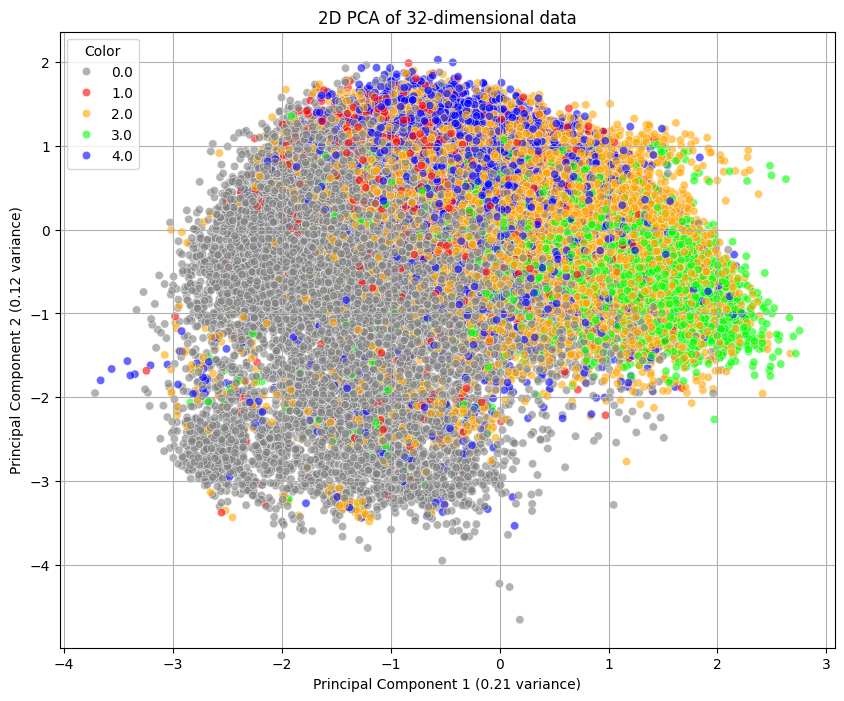

In [16]:
plot_pca_2d(embeddings_array_ref, labels_array_ref, percentage=0.02)

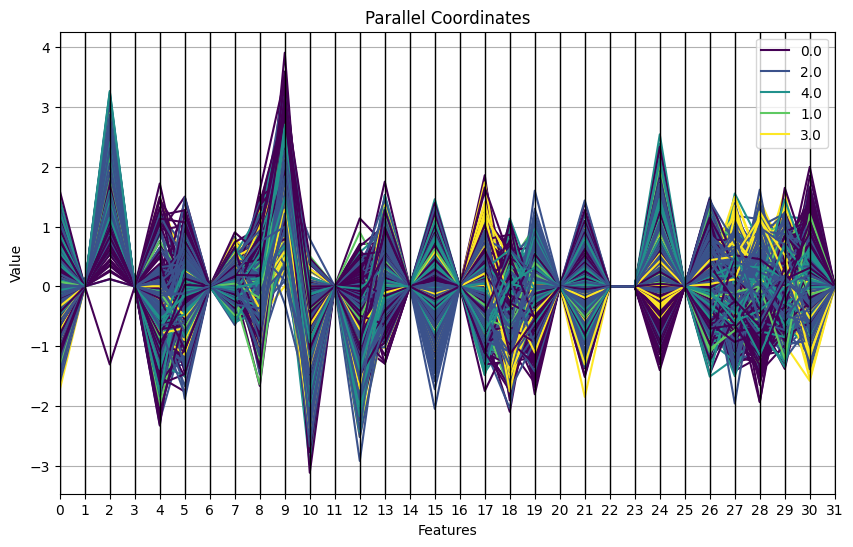

In [142]:
from pandas.plotting import parallel_coordinates

data = embeddings_array_ref
colors = labels_array_ref
percentage = 0.0005

# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(data)

if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        data = embeddings_array_ref[random_indices]
        colors = colors[random_indices]

df = pd.DataFrame(data[:,:])
df['phase'] = colors

# Creare il Parallel Coordinates Plot
plt.figure(figsize=(10, 6))
parallel_coordinates(df, 'phase', colormap='viridis')
plt.title('Parallel Coordinates')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

## Plotting the validation loss

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_from_csv(files, label, metric='val_loss'):
    colors = ['g', 'b', 'r']  # Define colors for the plots
    for i, file in enumerate(files):
        # Read the CSV file
        df = pd.read_csv(file)
        df = df.dropna(subset=[metric])
        # Extract 'Epoch' and 'Val_loss' columns
        epochs = df['step']/(df['step'].max()/df['epoch'].max())
        val_loss = df[metric]
        
        # Handle missing values by interpolating
        #val_loss = val_loss.interpolate()
        
        # Plot the values
        plt.plot(epochs, val_loss, color=colors[i], label=label[i])

    # Add labels and title
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.title('Validation Loss over Epochs')
    plt.legend()
    #plt.grid(True)
    plt.show()

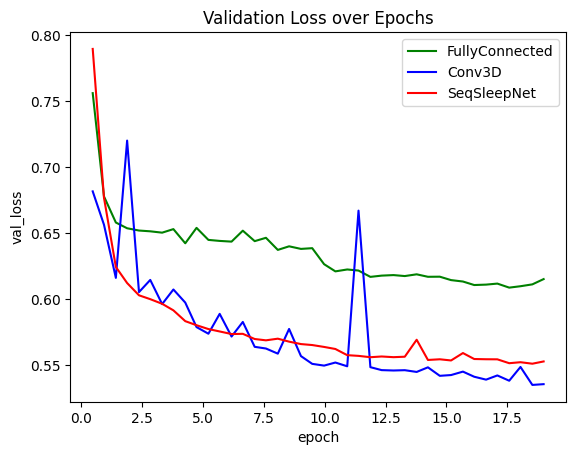

In [15]:
# List of CSV files
files = [
    'lightning_logs/ae_fullyconnected/seqlen=3/merged_mass/EEG/version_4/metrics.csv',
    'lightning_logs/ae_conv3d/seqlen=3/merged_mass/EEG/version_2/metrics.csv',     
    'lightning_logs/ae_seqsleepnet/seqlen=3/merged_mass/EEG/version_1/metrics.csv'
]

# Call the function to plot the data
plot_from_csv(files, ['FullyConnected','Conv3D', 'SeqSleepNet'], 'val_loss')

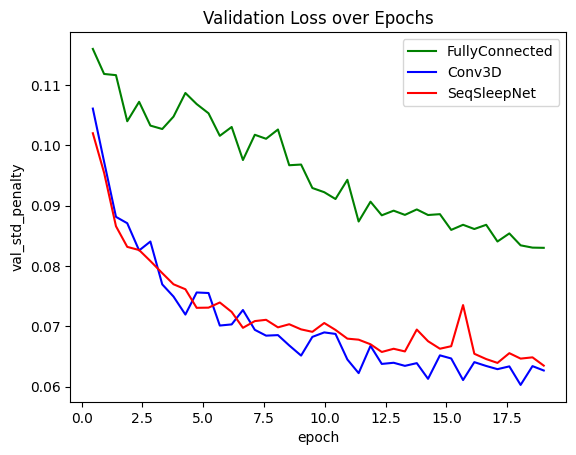

In [16]:
plot_from_csv(files, ['FullyConnected','Conv3D', 'SeqSleepNet'], metric='val_std_penalty')

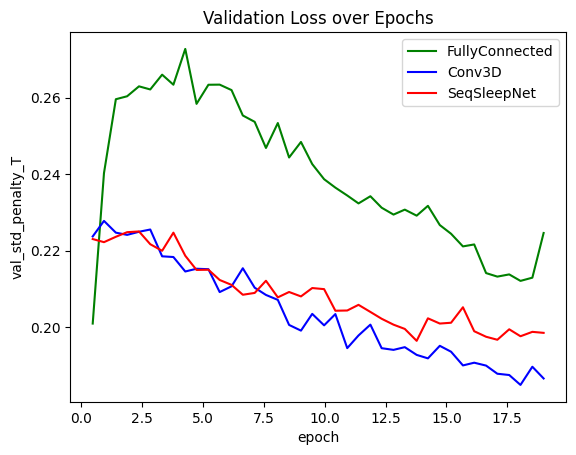

In [17]:
plot_from_csv(files, ['FullyConnected','Conv3D', 'SeqSleepNet'], metric='val_std_penalty_T')

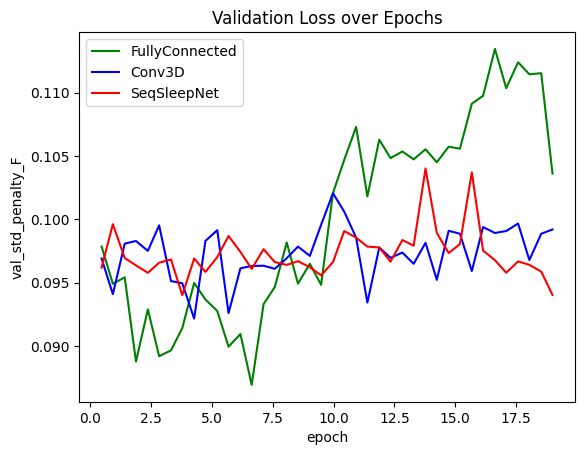

In [19]:
plot_from_csv(files, ['FullyConnected','Conv3D', 'SeqSleepNet'], metric='val_std_penalty_F')